# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [31]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [33]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [34]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,)
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## np.ones_like

In [35]:
a = np.array([5, 6, 7])
print(np.ones_like(a))

[1 1 1]


Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [47]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [51]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.0067606

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращать и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [83]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

$$ L(s|cl=k, y) = \frac{1}{\text{num batches}} \sum_{s} -\ln \frac{e^{y_k}}{\sum_{j} e^{y_j}}$$

In [97]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [105]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [107]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [115]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.3965340329112257
Epoch 1, loss: 2.330564226644023
Epoch 2, loss: 2.3110262936007815
Epoch 3, loss: 2.3045869406277295
Epoch 4, loss: 2.303294279937089
Epoch 5, loss: 2.3030614150114315
Epoch 6, loss: 2.3021409553685923
Epoch 7, loss: 2.301890954651955
Epoch 8, loss: 2.3018759531207764
Epoch 9, loss: 2.3015581742717415


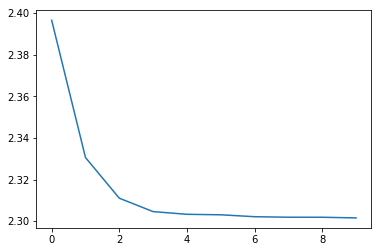

In [116]:
# let's look at the loss history!
plt.plot(loss_history)

In [117]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.147
Epoch 0, loss: 2.3017809726056893
Epoch 1, loss: 2.3016584163477747
Epoch 2, loss: 2.3017808145501646
Epoch 3, loss: 2.30224489445477
Epoch 4, loss: 2.3022370579950127
Epoch 5, loss: 2.301790877559601
Epoch 6, loss: 2.3024923938668778
Epoch 7, loss: 2.301377840521881
Epoch 8, loss: 2.3017975024910986
Epoch 9, loss: 2.302487790659727
Epoch 10, loss: 2.30138275053864
Epoch 11, loss: 2.302699286540833
Epoch 12, loss: 2.302273776225491
Epoch 13, loss: 2.301578028596801
Epoch 14, loss: 2.3017263193919324
Epoch 15, loss: 2.301769818161315
Epoch 16, loss: 2.3032190938870336
Epoch 17, loss: 2.302017171319028
Epoch 18, loss: 2.3020455577037584
Epoch 19, loss: 2.3025151457759887
Epoch 20, loss: 2.3019283554368477
Epoch 21, loss: 2.3013036432963867
Epoch 22, loss: 2.3014318021434224
Epoch 23, loss: 2.301520491039292
Epoch 24, loss: 2.3018187369881633
Epoch 25, loss: 2.301805514789684
Epoch 26, loss: 2.301658787013129
Epoch 27, loss: 2.301594521846366
Epoch 28, loss: 2.30235813719

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [118]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for rate in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=rate, batch_size=300, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.3020547415513066
Epoch 1, loss: 2.30300158396119
Epoch 2, loss: 2.2999952811821993
Epoch 3, loss: 2.298421508481056
Epoch 4, loss: 2.2998776531524476
Epoch 5, loss: 2.295894137419275
Epoch 6, loss: 2.298857697045298
Epoch 7, loss: 2.295741460067322
Epoch 8, loss: 2.2961443405613413
Epoch 9, loss: 2.294004066150274
Epoch 10, loss: 2.2934586467201092
Epoch 11, loss: 2.2902424758541056
Epoch 12, loss: 2.29452705434579
Epoch 13, loss: 2.2897872231486214
Epoch 14, loss: 2.2916177826454374
Epoch 15, loss: 2.2883429936880355
Epoch 16, loss: 2.288845213123228
Epoch 17, loss: 2.2850249756582603
Epoch 18, loss: 2.2904916614317967
Epoch 19, loss: 2.2895435068990584
Epoch 20, loss: 2.2886766193876964
Epoch 21, loss: 2.291628880512785
Epoch 22, loss: 2.28731222589776
Epoch 23, loss: 2.28330447089635
Epoch 24, loss: 2.2875781025707416
Epoch 25, loss: 2.281797413701343
Epoch 26, loss: 2.2803020705091774
Epoch 27, loss: 2.278440036268377
Epoch 28, loss: 2.2748223485644625
Epoch 29, lo

Epoch 35, loss: 2.278586369989152
Epoch 36, loss: 2.2782652358886177
Epoch 37, loss: 2.278743517693145
Epoch 38, loss: 2.2706322078471004
Epoch 39, loss: 2.2775034118133486
Epoch 40, loss: 2.2694780554525704
Epoch 41, loss: 2.2743542547552615
Epoch 42, loss: 2.27972040111153
Epoch 43, loss: 2.2697025294781294
Epoch 44, loss: 2.2683386750736005
Epoch 45, loss: 2.268531269483783
Epoch 46, loss: 2.271276640866529
Epoch 47, loss: 2.2596570548573642
Epoch 48, loss: 2.2795834648281335
Epoch 49, loss: 2.261260438835457
Epoch 50, loss: 2.269422793968195
Epoch 51, loss: 2.260008936409128
Epoch 52, loss: 2.267561205100133
Epoch 53, loss: 2.2731842566106435
Epoch 54, loss: 2.2629820832187337
Epoch 55, loss: 2.2709219961732003
Epoch 56, loss: 2.2634659216719824
Epoch 57, loss: 2.259932404173006
Epoch 58, loss: 2.2660008154684617
Epoch 59, loss: 2.2607761472116543
Epoch 60, loss: 2.2620550275152635
Epoch 61, loss: 2.2782604697429987
Epoch 62, loss: 2.2442508808847066
Epoch 63, loss: 2.2610905947596

Epoch 71, loss: 2.251273976010379
Epoch 72, loss: 2.2459229392258466
Epoch 73, loss: 2.2563718758549958
Epoch 74, loss: 2.261472858226274
Epoch 75, loss: 2.251394134844682
Epoch 76, loss: 2.245890407232335
Epoch 77, loss: 2.240200306050348
Epoch 78, loss: 2.2344660715623177
Epoch 79, loss: 2.264748758664189
Epoch 80, loss: 2.2521419345545053
Epoch 81, loss: 2.2493971357926115
Epoch 82, loss: 2.260891846085904
Epoch 83, loss: 2.2487417609864577
Epoch 84, loss: 2.2413043134241946
Epoch 85, loss: 2.247562061295065
Epoch 86, loss: 2.2488218908622
Epoch 87, loss: 2.2426090039729534
Epoch 88, loss: 2.2446425253524267
Epoch 89, loss: 2.2458524560418796
Epoch 90, loss: 2.2590468048602736
Epoch 91, loss: 2.2445005762112995
Epoch 92, loss: 2.243971361352263
Epoch 93, loss: 2.2394373555949
Epoch 94, loss: 2.251084900981867
Epoch 95, loss: 2.2445770557887497
Epoch 96, loss: 2.2316644784791286
Epoch 97, loss: 2.2495150045390626
Epoch 98, loss: 2.2436852378193066
Epoch 99, loss: 2.241251425770054
Ep

Epoch 106, loss: 2.289834762795454
Epoch 107, loss: 2.295470076317415
Epoch 108, loss: 2.2936140000754146
Epoch 109, loss: 2.2922190798659208
Epoch 110, loss: 2.294758592842262
Epoch 111, loss: 2.293717434175365
Epoch 112, loss: 2.2954895900634296
Epoch 113, loss: 2.292995887862225
Epoch 114, loss: 2.2976499602538656
Epoch 115, loss: 2.2925939182932105
Epoch 116, loss: 2.2929079643023096
Epoch 117, loss: 2.292153466034037
Epoch 118, loss: 2.2959702267362325
Epoch 119, loss: 2.2893511721621
Epoch 120, loss: 2.2934636966825606
Epoch 121, loss: 2.2910831745932208
Epoch 122, loss: 2.292772776385925
Epoch 123, loss: 2.2911426470848713
Epoch 124, loss: 2.294706377628296
Epoch 125, loss: 2.2952148906181447
Epoch 126, loss: 2.295312462087526
Epoch 127, loss: 2.2925999595861617
Epoch 128, loss: 2.292275239084584
Epoch 129, loss: 2.2916048340184
Epoch 130, loss: 2.2932192320848404
Epoch 131, loss: 2.2881297159739544
Epoch 132, loss: 2.293007804714885
Epoch 133, loss: 2.292127394961529
Epoch 134,

Epoch 140, loss: 2.2928881596732067
Epoch 141, loss: 2.293607230395926
Epoch 142, loss: 2.2928791875195116
Epoch 143, loss: 2.2915133483788868
Epoch 144, loss: 2.29436461377042
Epoch 145, loss: 2.291944863911751
Epoch 146, loss: 2.290127085938289
Epoch 147, loss: 2.2967261738719973
Epoch 148, loss: 2.2907765653651886
Epoch 149, loss: 2.288432936089086
Epoch 150, loss: 2.289944767742624
Epoch 151, loss: 2.2898488840239075
Epoch 152, loss: 2.2897890081021135
Epoch 153, loss: 2.288357728864753
Epoch 154, loss: 2.2899753883170586
Epoch 155, loss: 2.2894812746609587
Epoch 156, loss: 2.2918063101739055
Epoch 157, loss: 2.2918536349420657
Epoch 158, loss: 2.2938800301624274
Epoch 159, loss: 2.288261163004332
Epoch 160, loss: 2.289751472431619
Epoch 161, loss: 2.2900688376233505
Epoch 162, loss: 2.290354504681741
Epoch 163, loss: 2.2906721562279557
Epoch 164, loss: 2.290181008857481
Epoch 165, loss: 2.2910699495192537
Epoch 166, loss: 2.2885838504985463
Epoch 167, loss: 2.2892529786005786
Epoc

Epoch 174, loss: 2.2880734972782895
Epoch 175, loss: 2.286864190048921
Epoch 176, loss: 2.2872510988034693
Epoch 177, loss: 2.2891631612737844
Epoch 178, loss: 2.2865617019433437
Epoch 179, loss: 2.291130164214973
Epoch 180, loss: 2.289601923440519
Epoch 181, loss: 2.292679267703635
Epoch 182, loss: 2.289098016086289
Epoch 183, loss: 2.290990317110919
Epoch 184, loss: 2.289960469050366
Epoch 185, loss: 2.2831079927753875
Epoch 186, loss: 2.2882860936865
Epoch 187, loss: 2.2893967139050155
Epoch 188, loss: 2.287669860035468
Epoch 189, loss: 2.286195900504974
Epoch 190, loss: 2.2877059135583675
Epoch 191, loss: 2.291465530308101
Epoch 192, loss: 2.28060497500531
Epoch 193, loss: 2.2872857370078745
Epoch 194, loss: 2.281280692196963
Epoch 195, loss: 2.2821132189980045
Epoch 196, loss: 2.2837958757084986
Epoch 197, loss: 2.2878588645524722
Epoch 198, loss: 2.287259927692283
Epoch 199, loss: 2.2865650055871813
Epoch 0, loss: 2.3030647502060617
Epoch 1, loss: 2.302972600051273
Epoch 2, loss:

Epoch 9, loss: 2.3032574188356523
Epoch 10, loss: 2.3040767868731877
Epoch 11, loss: 2.303238374124113
Epoch 12, loss: 2.302486568008024
Epoch 13, loss: 2.3033536981082237
Epoch 14, loss: 2.3025503990111247
Epoch 15, loss: 2.3033119937757007
Epoch 16, loss: 2.3020549394149383
Epoch 17, loss: 2.301928370264575
Epoch 18, loss: 2.3016099651018687
Epoch 19, loss: 2.301960135989311
Epoch 20, loss: 2.3026956541461723
Epoch 21, loss: 2.302165958969642
Epoch 22, loss: 2.3022057797799733
Epoch 23, loss: 2.3024966004837784
Epoch 24, loss: 2.304051094308607
Epoch 25, loss: 2.303000720327835
Epoch 26, loss: 2.303410867408892
Epoch 27, loss: 2.302200697743775
Epoch 28, loss: 2.3036027996813644
Epoch 29, loss: 2.301979113958714
Epoch 30, loss: 2.301749720199078
Epoch 31, loss: 2.3023936175597135
Epoch 32, loss: 2.302622509697735
Epoch 33, loss: 2.3024522453287766
Epoch 34, loss: 2.302680631844751
Epoch 35, loss: 2.302659909784587
Epoch 36, loss: 2.301935642350306
Epoch 37, loss: 2.302697344583147
Ep

Epoch 44, loss: 2.302004616679378
Epoch 45, loss: 2.3027330060670446
Epoch 46, loss: 2.3017696530335896
Epoch 47, loss: 2.3029675614985523
Epoch 48, loss: 2.302741928592443
Epoch 49, loss: 2.3022934794021075
Epoch 50, loss: 2.302357909406277
Epoch 51, loss: 2.3019908641429123
Epoch 52, loss: 2.3022132022291326
Epoch 53, loss: 2.3021282021922156
Epoch 54, loss: 2.301955601165458
Epoch 55, loss: 2.3019417086023677
Epoch 56, loss: 2.302644672930024
Epoch 57, loss: 2.3019554645749323
Epoch 58, loss: 2.3017991925772643
Epoch 59, loss: 2.3014065697156543
Epoch 60, loss: 2.3016986862813282
Epoch 61, loss: 2.301546370995221
Epoch 62, loss: 2.301497368768607
Epoch 63, loss: 2.3019251156017155
Epoch 64, loss: 2.30247221613649
Epoch 65, loss: 2.3020476940051746
Epoch 66, loss: 2.3014147829392346
Epoch 67, loss: 2.3010215868815145
Epoch 68, loss: 2.301083234149949
Epoch 69, loss: 2.3015020162167636
Epoch 70, loss: 2.3019104377878725
Epoch 71, loss: 2.30161253717761
Epoch 72, loss: 2.30169246281298

# Какой же точности мы добились на тестовых данных?

In [119]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.213000
